In [1]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [2]:
import importlib
importlib.reload(cluster_model)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash 48b7df48740ded40fd9b18f95c5c4b5a3adb21d8
Created dataset
0 8192
8192 16152
0 8192
8192 16152
0 8192
8192 16152
0 8192
8192 16152
0 8192
8192 16152
0 8192
8192 16152
Got embeddings
Getting cluster scores for lattice
Set all initial to 0
Set predictions for layer 0
Set predictions for layer 1
Set predictions for layer 2
Set predictions for layer 3
Set predictions for layer 4
Set predictions for layer 5
Set all probs with predictions
Scoring layer 0
COEFF STUFF 1.0 0.0 (512, 512) -0.4368 0.9992831
Scoring layer 1
COEFF STUFF 1.0 0.0 (512, 512) -0.22478417 0.9979379
Scoring layer 2
COEFF STUFF 1.0 6e-45 (512, 512) -0.29336807 0.9965437
Scoring layer 3
COEFF STUFF 1.0 1e-45 (512, 512) -0.4262962 0.99800146
Scoring layer 4
COEFF STUFF 1.0 1.57e-43 (512, 512) -0.39667317 0.99514043
CLUSTER SCORES [array([[ 8.80119449e-04, -8.70140066e-05, -1.89080441e-04, ...,
         3.38209909e-04,  3.41786945e-04, -1.19678210e-04],
       [ 3.99375014e-04,  6.215229

In [3]:
decomp.lattice_scores[0].shape

(512, 512)

In [4]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

2481.1245
0.0


## Isolate Specific Neurons

In [5]:
import numpy as np

def get_weighting_for_layer(layer: int, n_layers: int, weight_decay=0.95):
    r = np.ones(n_layers)
    r[layer] = 1
    G = weight_decay
    for i in range(layer):
        r[i] = G ** (layer - i)
    for i in range(layer + 1, n_layers):
        # Decrease by Gx per layer
        r[i] = G ** (i - layer)
    return r
    

In [6]:
decomp.lattice_scores[0][:, 13]

array([ 9.53756156e-04, -1.46238395e-04, -5.21550101e-05,  1.44492183e-03,
       -2.51675287e-04,  8.74226540e-03,  3.57830822e-01, -9.73155475e-05,
        1.89055363e-03,  2.27263983e-04,  1.16086390e-03,  4.06866980e-04,
        9.07748297e-04,  4.35879797e-01,  5.98664545e-02,  8.59496649e-04,
        1.72089014e-04,  5.28782187e-03,  1.18444499e-03,  4.02953103e-03,
        2.14849841e-02,  1.53481506e-05,  4.81037889e-03, -1.71176053e-03,
        2.81736226e-04,  4.41557109e-01, -3.29035480e-04,  3.21431924e-03,
        9.13646247e-04,  7.20268945e-05,  1.37705973e-03,  3.58268176e-03,
        2.33957112e-01, -7.02452380e-05,  1.31896436e-02, -2.85899267e-04,
        2.10651127e-03,  3.58799909e-04,  4.65350077e-02,  2.15234943e-02,
        2.00184342e-03,  5.53112710e-03,  1.71419363e-02,  1.53035447e-02,
       -1.41524288e-04,  9.62452311e-03,  2.37908244e-01,  4.35239188e-02,
       -4.18601012e-05, -1.02118232e-04,  1.51363648e-02,  4.89118755e-01,
        8.79599174e-05,  

In [7]:
importlib.reload(utils)
# TODO: restrict lattice, change picture instead of starting elsewhere...
# ~~Use source~~ node
# TODO: ~~SOMEHOW LAYER 2 is where stuff happens~~
cutoff = 0.3
scores_cutoff = [m * m > cutoff for m in modified_lattice]
paths = utils.top_k_dag_paths(decomp.lattice_scores, layer=1, neuron=13, k=50)
paths

([205, 13, 306, 44, 99, 300], 4.708668737564087)
([205, 13, 306, 44, 99, 400], 4.692148737564087)
([135, 13, 306, 44, 99, 300], 4.682488737564087)
([135, 13, 306, 44, 99, 400], 4.665968737564087)
([205, 13, 306, 403, 256, 300], 4.627708737564086)
([205, 13, 22, 444, 332, 300], 4.618488737564087)
([205, 13, 306, 403, 256, 400], 4.613758737564087)
([297, 13, 306, 44, 99, 300], 4.606148737564087)
([205, 13, 22, 444, 332, 400], 4.602088737564086)
([135, 13, 306, 403, 256, 300], 4.601528737564087)
([135, 13, 22, 444, 332, 300], 4.592308737564087)
([297, 13, 306, 44, 99, 400], 4.589628737564087)
([135, 13, 306, 403, 256, 400], 4.587578737564087)
([87, 13, 306, 44, 99, 300], 4.5764687375640865)
([135, 13, 22, 444, 332, 400], 4.575908737564087)
([87, 13, 306, 44, 99, 400], 4.559948737564087)
([205, 13, 306, 44, 99, 332], 4.525758737564087)
([297, 13, 306, 403, 256, 300], 4.525188737564087)
([371, 13, 306, 44, 99, 300], 4.517448737564087)
([297, 13, 22, 444, 332, 300], 4.515968737564087)


KeyboardInterrupt: 

## Setup for scoring and visualization

In [ ]:
import math
import numpy as np
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render

/tmp/ipykernel_201349/672954307.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Try different scoring method

In [ ]:
# # TODO: scoring and testing the paths

# importlib.reload(cluster_model)

# # score_path = [69, 2, 493, 289, 511, 48]
# # TODO: embeds to here...
# to_score = ds
# to_score_adj = [s[:300] for s in to_score][:300]
# to_score = to_score_adj
# importlib.reload(cluster_model)
# # TODO: should we work over log everywhere?
# _, top_ds, scores = cluster_model.score_for_neuron(decomp, to_score_adj, LAYER, score_path, top_n=200, weighting_per_layer=get_weighting_for_layer(LAYER, N_BLOCKS))

# def get_renderable_scores(scored_t: List[str], scores: List


# scores_per_token_set = np.array([max(s) for s in scores])
# top_args = np.argsort(scores_per_token_set)[::-1]

# # scores_per_token_set = [max(s) for s in scores]
# # top_args = [s.argmax() for s in scores]

# to_score_top = [to_score[i] for i in top_ds]

# tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
#     'input_ids']] for d in to_score_top]
# tokens_reord = [tokens[i] for i in top_args]
# scores_reord = [scores[i] for i in top_args]

# # TODO: WHAT IS HAPPENING WITH NAN?
# act_simp = [[[[math.exp(10 * tok)]]
#              for tok in s] for s in scores_reord]
# # TODO sep fun
# html = render(
#     "TextNeuronActivations",
#     tokens=tokens_reord,
#     activations=act_simp,
#     firstDimensionName="Layer",
#     secondDimensionName="Neuron",
#     firstDimensionLabels=None,
#     secondDimensionLabels=None
# )
# display(HTML(str(html)))

## Try more path like method

In [ ]:
"""
score_path = [13, 13, 391, 57, 57, 57]... relates to laws/ licensing
"""

# TODO: SIOMETHING WRONG HERE WITH THE PATHS
import numpy as np
import metric
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(metric)
# score_path = [70, 13, 59, 423, 368, 418]
score_path = [105, 13, 460, 112, 87, 402] # Opening " in code block thing?
LAYER = 1
# score_path = [0, 0, 69, 51, 195, 99]
# score_path = [69, 1, 107, 289, 97, 508]

"""
Paths which seem to have meaning:

"""

weighting_per_layer = get_weighting_for_layer(LAYER, N_BLOCKS, weight_decay=0.9)
# weighting_per_layer[0] = 0
# weighting_per_layer[1] = 0
print(weighting_per_layer)
to_score = [d[:300] for d in ds][:200]
scores = decomp.score(
    to_score,
    score_path=score_path,
    # TODO: how do we weight???
    weighting_per_layer=weighting_per_layer,
    use_log_scores=True
)

scores_per_token_set = np.array([max(s) for s in scores])
top_args = np.argsort(scores_per_token_set)[::-1]

# TODO: we have the weights here

tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
    'input_ids']] for d in to_score]
tokens_reord = [tokens[i] for i in top_args]
scores_reord = [scores[i] for i in top_args]

[0.9    1.     0.9    0.81   0.729  0.6561]
GOT EMBEDS (6, 14946, 512)
(14946, 6, 512) [105, 13, 460, 112, 87, 402]


In [ ]:
# TODO: what up with this max
max_score = max(max(s for s in scores_reord))
max_score

-88.25711509342685

In [ ]:
import math
from IPython.core.display import display, HTML
import math
import numpy as np

act_simp = [[[[math.exp(tok - max_score)]]
             for tok in s] for s in scores_reord]
# TODO sep fun
html = render(
    "TextNeuronActivations",
    tokens=tokens_reord,
    activations=act_simp,
    firstDimensionName="Layer",
    secondDimensionName="Neuron",
    firstDimensionLabels=None,
    secondDimensionLabels=None
)
display(HTML(str(html)))

/tmp/ipykernel_201349/618490781.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

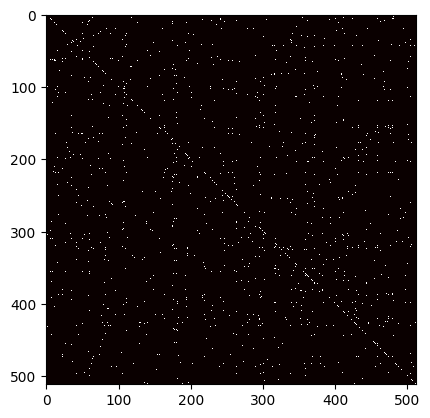

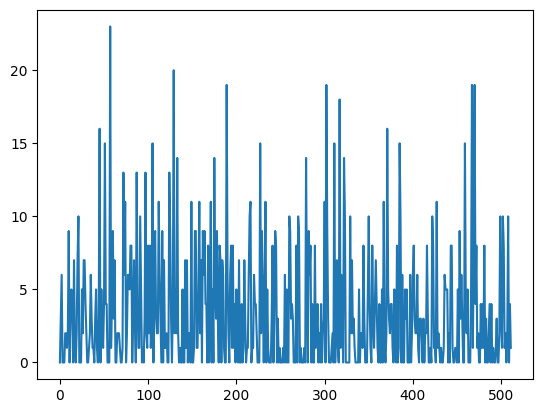

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.1

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))